In [39]:
import networkx as nx
import scipy.linalg as linalg
from sensors import utils, flows
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsmr

In [63]:
class NoisyEvaluator(flows.lazy.LazyEvaluator):
    
    def __init__(self, G, true_edges, noise=1.5):
        noisy_edges = {}
        sigma = noise * np.std(list(true_edges.values()))
        for e, f in true_edges.items():
            noisy_edges[e] = f + np.random.normal(0, sigma)
                
        super().__init__(G, noisy_edges)
        self.true_edges = true_edges 
        
    def denoise(self, alpha):
        B = nx.incidence_matrix(self.G, oriented=True)
        m = self.G.number_of_edges()
        X = alpha * B.T @ B + np.identity(m)
        f_noisy = utils.metrics.dict2vect(self.G, self.labeled_edges)
        return utils.metrics.vect2dict(self.G, lsmr(X, f_noisy)[0])
        
    def evaluate(self, sensors):
        return utils.metrics.mse(flows.flow_prediction(self.G, {e: self.labeled_edges[e] for e in sensors}), self.labeled_edges)
    
    def predict(self, sensors):
        return flows.flow_prediction(self.G, {s: self.true_edges[s] for s in sensors})
    
    def get_pred_correlation(self, sensors):
        pred = self.predict(sensors)
        return np.corrcoef([pred[e] for e in self.true_edges], 
                           [self.true_edges[e] for e in self.true_edges])[0][1]
            
    def al_flows_rrqr(self, ratio):
        f = utils.metrics.dict2vect(self.G, self.labeled_edges)
        B = nx.incidence_matrix(self.G, oriented=True)
        V_C = linalg.null_space(B.todense())
        
        f_C = V_C @ V_C.T @ denoise(self.G, f, 1)
        
        Q, R, p = linalg.qr(V_C.T @ np.diag(f_C), pivoting=True)
        
        sensors = []
        edges = list(self.G.edges())
        for i in range(int(ratio * len(self.labeled_edges))):
            sensors.append(edges[p[i]])
        
        return sensors
    
    def get_results(self):
        results = super().get_results()
        noisy_corr = np.corrcoef(utils.metrics.dict2vect(self.G, self.true_edges), 
                                 utils.metrics.dict2vect(self.G, self.labeled_edges))[0][1]
        results["noisy"] = {i / 10: noisy_corr for i in range(11)}
        return results

In [57]:
evaluator = NoisyEvaluator(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp"))

In [64]:
results = {}

results["Anaheim"] = NoisyEvaluator(*utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")).get_results()
# results["Barcelona"] = NoisyEvaluator(*utils.data.read_tntp_graph("data/Barcelona/Barcelona_flow.tntp")).get_results()
# results["Chicago"] = NoisyEvaluator(*utils.data.read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")).get_results()
# results["Winnipeg"] = NoisyEvaluator(*utils.data.read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp")).get_results()

100%|█████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.61it/s]


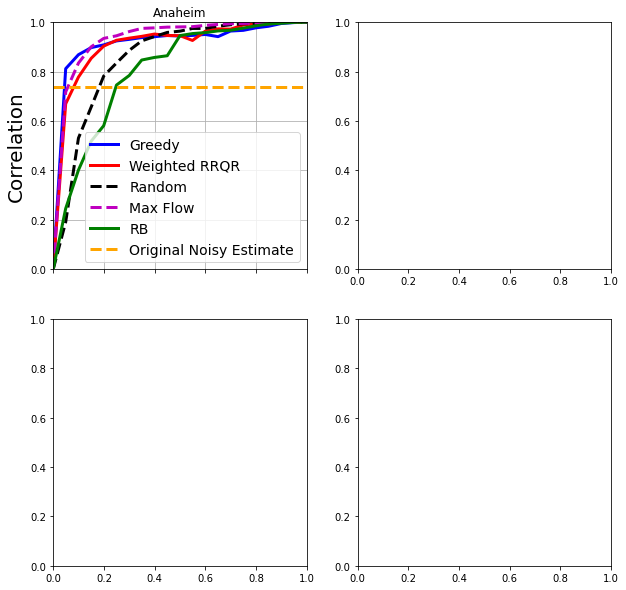

In [62]:
def plot_results(results, ax, title, xlabel=False, ylabel=False, legend=False):
    ax.plot(results["greedy"].keys(), results["greedy"].values(), "b", label="Greedy",
           linewidth=3)
    ax.plot(results["rrqr"].keys(), results["rrqr"].values(), "r", label="Weighted RRQR",
           linewidth=3)
    ax.plot(results["random"].keys(), results["random"].values(), "black", label="Random",
           linewidth=3, linestyle="dashed")
    ax.plot(results["max"].keys(), results["max"].values(), "m", label="Max Flow",
           linewidth=3, linestyle="dashed")
    ax.plot(results["rb"].keys(), results["rb"].values(), "g", label="RB",
           linewidth=3)
    ax.plot(results["noisy"].keys(), results["noisy"].values(), "orange", label="Original Noisy Estimate",
           linewidth=3, linestyle="dashed")
        
    if legend:
        ax.legend(fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if xlabel:
        ax.set_xlabel("Number of Sensors (%)", fontsize=20)
    else:
        ax.set_xticklabels([])
    if ylabel:
        ax.set_ylabel("Correlation", fontsize=20)
    else:
        ax.set_yticklabels([])
    ax.grid("on")
    ax.set_title(title)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_results(results["Anaheim"], ax[0][0], "Anaheim", ylabel=True, legend=True)
# plot_results(results["Barcelona"], ax[0][1], "Barcelona")
# plot_results(results["Chicago"], ax[1][0], "Chicago", xlabel=True, ylabel=True)
# plot_results(results["Winnipeg"], ax[1][1], "Winnipeg", xlabel=True)
# plt.savefig("results/noisyflows.png")

In [121]:
def plot_spectral_coefs(G, flow, ax, title, xlabel=False, ylabel=False):
    n, m = G.number_of_nodes(), G.number_of_edges()

    B = nx.incidence_matrix(G, oriented=True).toarray()
    U, s, Vh = linalg.svd(B)
    Sigma = linalg.diagsvd(s, U.shape[1], Vh.shape[0])
    s = list(s) + [0] * (m - n)
    
    p = Vh @ flow 
    
    ax.scatter(range(G.number_of_edges(), 0, -1), p)
    ax.axvline(x=G.number_of_edges() - G.number_of_nodes() + 1, c="black", linestyle="dashed")
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel("Rank")
    if ylabel:
        ax.set_ylabel("Spectral Coefficient")

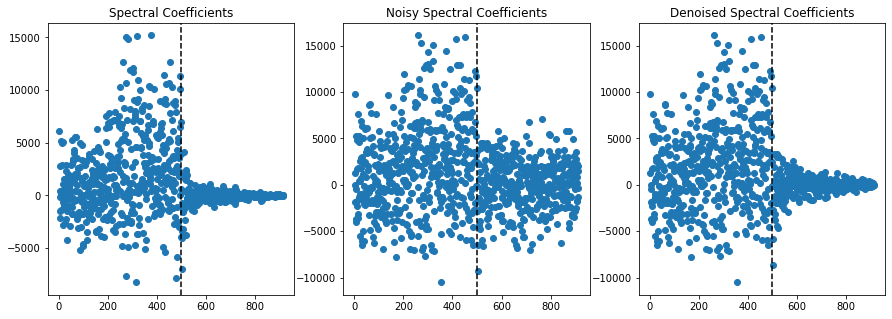

In [130]:
G, true_edges = utils.data.read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
f = utils.metrics.dict2vect(G, true_edges)
eps = np.random.normal(0, np.std(f), len(f))
B = nx.incidence_matrix(G, oriented=True)
V_R = linalg.orth(B.T.todense())
V_C = linalg.null_space(B.todense())
D = np.diag([G.number_of_nodes() * G.degree(v) / (2 * G.number_of_edges()) for v in G.nodes()])
k = int(G.number_of_edges() / 10)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_spectral_coefs(G, f, ax[0], "Spectral Coefficients")
plot_spectral_coefs(G, f + eps, ax[1], "Noisy Spectral Coefficients")
plot_spectral_coefs(G, denoise(G, f + eps, 1), ax[2], "Denoised Spectral Coefficients")
# plt.savefig("results/denoising.png")

In [131]:
import json

with open("data/Anaheim/anaheim_nodes.geojson") as file:
    features = json.loads(file.read())["features"]

coords = {}
for feat in features:
    coords[feat["properties"]["id"]] = feat["geometry"]["coordinates"]

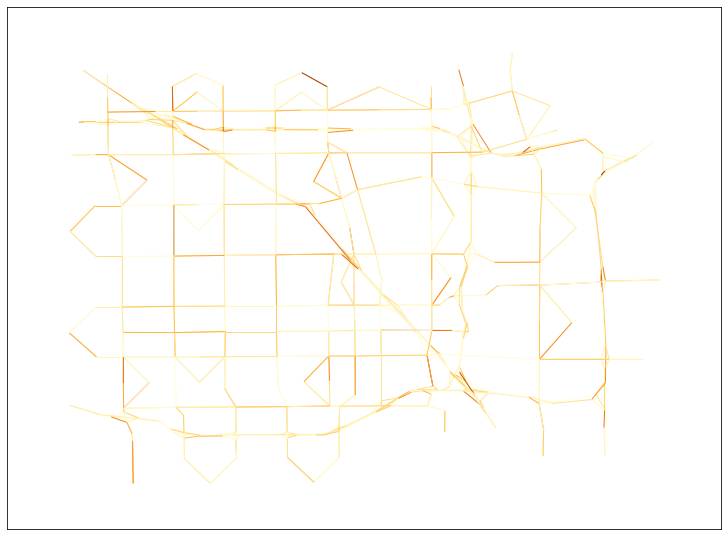

In [134]:
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=abs(eps),
        arrows=False,
        edge_cmap=plt.cm.YlOrBr)

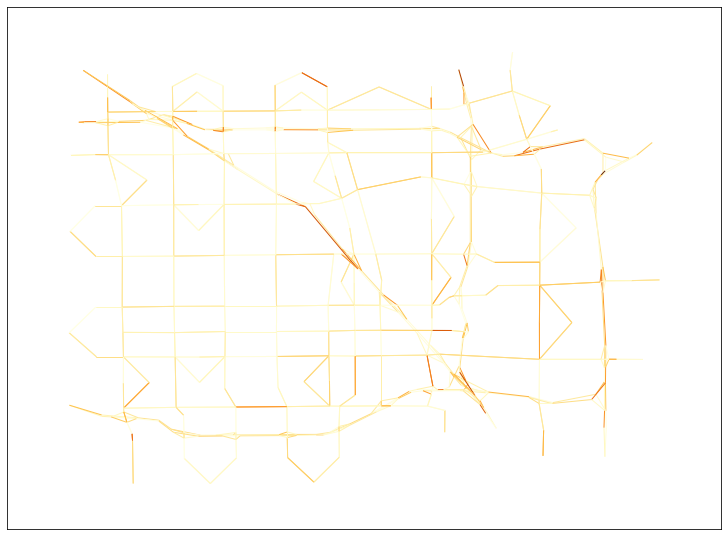

In [133]:
plt.figure(figsize=[2 * x for x in [6.4, 4.8]])
nx.draw_networkx_edges(G, coords, 
        edge_color=abs(V_R @ V_R.T @ (f + eps)),
        arrows=False,
        edge_cmap=plt.cm.YlOrBr)